In [171]:
import numpy as np
import matplotlib.pyplot as plt

import numba
from numba import jit

In [172]:
nx = ny = 5
dx = 0.25
u0 = np.zeros((ny,nx))
b = np.ones((ny,nx)) * 0.5 * 0.25 * 0.25

u0[:,-1] = 0
u0[-1,:] = 1
u0[0,:] = 1
u0[:,0] = 1

In [173]:
def l2_norm(p, p_ref):
    """
    Computes and returns the relative L2-norm of the difference
    between a solution p and a reference solution p_ref.
    If L2(p_ref) = 0, the function simply returns
    the L2-norm of the difference.

    Parameters
    ----------
    p : numpy.ndarray
        The solution as an array of floats.
    p_ref : numpy.ndarray
        The reference solution as an array of floats.

    Returns
    -------
    diff : float
        The (relative) L2-norm of the difference.
    """
    l2_diff = np.sqrt(np.sum((p - p_ref)**2))
    l2_ref = np.sqrt(np.sum(p_ref**2))
    if l2_ref > 1e-12:
        return l2_diff / l2_ref
    return l2_diff

In [174]:
@jit(nopython=True)
def l2_norm_jit(p, p_ref):
    l2_diff = np.sqrt(np.sum((p - p_ref)**2))
    l2_ref = np.sqrt(np.sum(p_ref**2))
    if l2_ref > 1e-12:
        return l2_diff / l2_ref
    return l2_diff

In [175]:
def jacobi(u0, b, maxiter = 20000, e_max = 1e-6):
    u = u0.copy()
    ny, nx = u.shape
    err = 1
    ite = 0
    conv = []
    
    for it in range(maxiter):
        uk = u.copy()
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                u[j,i] = 0.25*(uk[j-1,i] + uk[j,i-1] + uk[j+1,i] + uk[j,i+1] - b[j, i]) 
        ite += 1
        err = l2_norm(u, uk)
        
        u[-1,:] = 1
        u[0,:] = 1
        u[:,0] = 1
        conv.append(err)
        if err < e_max:
            break
    return u, conv, ite

In [176]:
@jit(nopython=True)
def jacobi_jit(u0, b, maxiter = 20000, e_max = 1e-6):
    u = u0.copy()
    ny, nx = u.shape
    err = 1
    ite = 0
    conv = []
    
    for it in range(maxiter):
        uk = u.copy()
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                u[j,i] = 0.25*(uk[j-1,i] + uk[j,i-1] + uk[j+1,i] + uk[j,i+1] - b[j, i]) 
        ite += 1
        err = l2_norm(u, uk)
        
        u[-1,:] = 1
        u[0,:] = 1
        u[:,0] = 1
        conv.append(err)
        if err < e_max:
            break
    return u, conv, ite

In [177]:
u1, conv_jacobi, ite1 = jacobi(u0, b)
x = y = np.linspace(0, (nx-1)*dx, nx)
print(ite1, e1)

36 7.981746184923672e-07


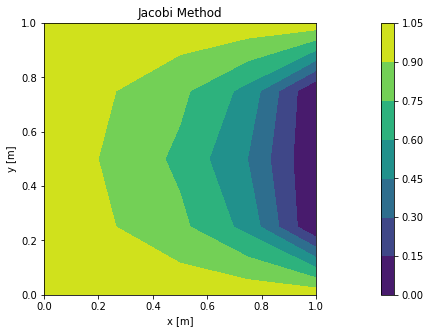

In [178]:
plt.figure(figsize=(8.0, 5.0))
plt.title('Jacobi Method')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
contf = plt.contourf(x, y, u1)
cbar = plt.colorbar(contf)
plt.axis('scaled', adjustable='box');

In [179]:
def gauss_seidel(p0, b, maxiter=10000, e_max = 1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    conv = []
    
    err = e_max + 1.0  # initial difference
    ite = 0  # iteration index
    while err > e_max and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (p[j, i - 1] + p[j, i + 1] +
                                  p[j - 1, i] + p[j + 1, i]- b[j,i])
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        # Compute the relative L2-norm of the difference.
        err = l2_norm(p, pn)
        conv.append(err)
        ite += 1
    return p, ite, conv

In [180]:
u2, it2, conv_gs = gauss_seidel(u0, b)
print(it2, e2)
print(u2)

32 0.0
[[1.         1.         1.         1.         1.        ]
 [1.         0.97646626 0.96735053 0.96680332 0.97479075]
 [1.         0.96976658 0.95738519 0.95632454 0.96555765]
 [1.         0.97646678 0.96735132 0.96680415 0.97479149]
 [1.         1.         1.         1.         1.        ]]


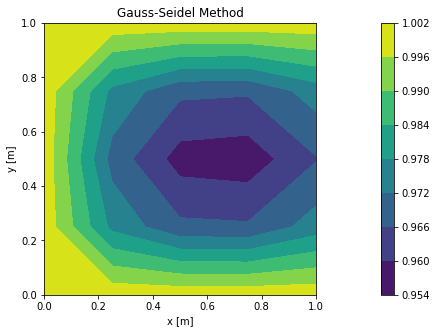

In [181]:
plt.figure(figsize=(8.0, 5.0))
plt.title('Gauss-Seidel Method')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
contf = plt.contourf(x, y, u2)
cbar = plt.colorbar(contf)
plt.axis('scaled', adjustable='box');

In [182]:
def SOR_method(p0, omega, maxiter=100, e_max=1e-6):
    ny, nx = p0.shape
    p = p0.copy()
    conv = []  # convergence history
    err = e_max + 1.0  # initial difference
    ite = 0  # iteration index
    while err > e_max and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = ((1.0 - omega) * p[j, i] +
                           omega * 0.25 *(p[j, i - 1] + p[j, i + 1] + p[j - 1, i] + p[j + 1, i]))
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        # Compute the relative L2-norm of the difference.
        err = np.sqrt(np.sum((p - pn)**2) / np.sum(pn**2))
        conv.append(err)
        ite += 1
    return p, ite, conv

In [183]:
omega = 1.0
u3, it3, conv_sor = SOR_method(u0, omega)
print(u3)

[[1.         1.         1.         1.         1.        ]
 [1.         0.99999839 0.99999757 0.99999741 0.99999772]
 [1.         0.99999814 0.9999972  0.99999702 0.99999737]
 [1.         0.99999893 0.99999838 0.99999828 0.99999848]
 [1.         1.         1.         1.         1.        ]]


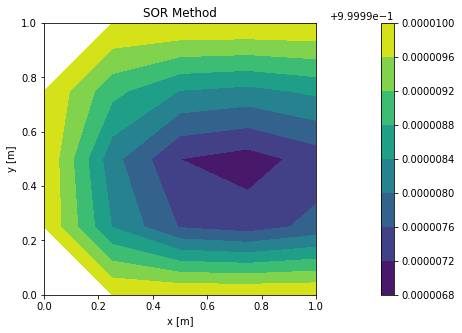

In [184]:
plt.figure(figsize=(8.0, 5.0))
plt.title('SOR Method')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
contf = plt.contourf(x, y, u3)
cbar = plt.colorbar(contf)
plt.axis('scaled', adjustable='box');

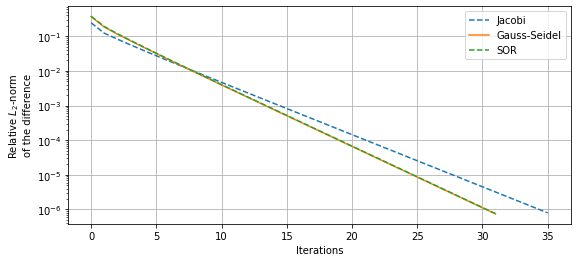

In [185]:
# Plot the convergence history for different methods.
plt.figure(figsize=(9.0, 4.0))
plt.xlabel('Iterations')
plt.ylabel('Relative $L_2$-norm\nof the difference')
plt.grid()
plt.semilogy(conv_jacobi, label='Jacobi', linestyle='--')
plt.semilogy(conv_gs, label='Gauss-Seidel')
plt.semilogy(conv_sor, label='SOR', linestyle='--')
#plt.semilogy(conv_opt_sor, label='Optimized SOR')
plt.legend()
#plt.xlim(0, 20000);

In [186]:
%%timeit
u_j, conv_j, ite_j = jacobi(u0, b)
x = y = np.linspace(0, (nx-1)*dx, nx)

962 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [187]:
%%timeit
u_jit, conv_jit, ite_jit = jacobi_jit(u0, b)
x = y = np.linspace(0, (nx-1)*dx, nx)
print(ite1, e1)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'l2_norm':[0m [1m[1mcannot determine Numba type of <class 'function'>[0m
[1m
File "<ipython-input-176-9c0d5af9a35d>", line 15:[0m
[1mdef jacobi_jit(u0, b, maxiter = 20000, e_max = 1e-6):
    <source elided>
        ite += 1
[1m        err = l2_norm(u, uk)
[0m        [1m^[0m[0m
[0m
This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new
